In [5]:
#first import dependencies, mainly jax and numpyro
import time
from tqdm import tqdm

#we change the config to use fp64
from jax.config import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import numpy as np
import arviz as az

from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_feasible,
    init_to_median,
    init_to_sample,
    init_to_uniform,
    init_to_value,
)
import pandas as pd
#read the data, please change to your data directory
data = pd.read_pickle('/home/dkn16/data.pkl')
FGnopol = data.beam.foregrounds.all_nopol
FGpol = data.beam.foregrounds.pleak
HI = data.beam.HI
noise = data.beam.noise
freqs = data.freqs

#we do not use superpixel scheme here, instead we fit every single sightline.
superpixel = 1

In [17]:
def get_data(dim,pol=False,x0=0,y0=0,freqs = 285,superpixel = None,selected = None):
    #dim,freqs: the datasize is (dim,dim,freqs)
    #pol(bool): if True, include the polarization leakage data
    #x0,y0: starting coordinates. e.g. pixels within x0:x0+dim will be included in the data.
    #superpixel: if larger than one, reshape the data to be (x_withinsp,y_withinsp,x_sp,y_sp,freq). In this case, data[0][0] is all pixels within superpixel (0,0)
    #selected: indexes to select several channels.
    
    #foreground
    if pol:
        sky = jnp.array(FGnopol+FGpol)[x0:x0+dim,y0:y0+dim,0:freqs].astype(jnp.float64)
    else:
        sky = jnp.array(FGnopol)[x0:x0+dim,y0:y0+dim,0:freqs].astype(jnp.float64)
    
    #HI signal
    cosmos = jnp.array(HI+noise)[x0:x0+dim,y0:y0+dim,0:freqs].astype(jnp.float64)
    
    #substract mean to 
    sky = sky - jnp.mean(sky,axis=(0,1))
    cosmos = cosmos - jnp.mean(cosmos,axis=(0,1))
    
    sky=sky.reshape((dim*dim,freqs))/1000
    cosmos=cosmos.reshape((dim*dim,freqs))/1000
    
    X = jnp.linspace(0., 1., sky.shape[1]).astype(jnp.float64)
    
    Y = sky+cosmos


    if superpixel is not None:
        Y = Y.reshape((dim,dim,freqs))
        Y = Y.reshape((int(dim/superpixel),superpixel,int(dim/superpixel),superpixel,freqs)).transpose((0,2,1,3,4))
        Y = Y.reshape((int(int(dim/superpixel)**2),-1,freqs)).transpose((1,0,2))

    
    if selected is not None:
        X = X[selected]
        Y = Y[...,selected]

    return X, Y

def reverse_data(data,superpixel=1):
    dim2 = data.shape[0]*data.shape[1]
    dim = int(np.sqrt(dim2))
    freqs = data.shape[-1]
    if superpixel>=1:
        data = data.reshape((int(dim/superpixel),int(dim/superpixel),superpixel,superpixel,freqs)).transpose((0,2,1,3,4))
        data = data.reshape((-1,freqs))
    return data

def reverse_data_batch(data,superpixel=1):
    #data = data.transpose((1,0,2))
    dim2 = data.shape[1]*data.shape[2]
    batch = data.shape[0]
    dim = int(np.sqrt(dim2))
    freqs = data.shape[-1]
    if superpixel>=1:
        data = data.reshape((batch,int(dim/superpixel),int(dim/superpixel),superpixel,superpixel,freqs)).transpose((0,1,3,2,4,5))
        data = data.reshape((batch,-1,freqs))
    return data

In [7]:
# RBF kernel for fg, exponential kernel for HI, and a diagonal noise kernel
def kernel(X, Z, var, length,var_HI,length_HI, noise, jitter=1.0e-16,is_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    deltaHI = jnp.abs((X[:, None] - Z) / length_HI)
    
    k_fg = 1.0e-2*var * jnp.exp(-0.5 * deltaXsq)
    k_HI = 1.0e-9*var_HI * jnp.exp(-0.5 * deltaHI)
    #k = var * jnp.exp(-0.5 * deltaXsq)
    if is_noise:
        k_HI += (noise*noise*1.0e-14 + jitter) * jnp.eye(X.shape[0])
        k_fg += k_HI
    return k_fg

# RBF kernel for fg, another RBF kernel for pol, exponential kernel for HI, and a diagonal noise kernel
def kernel_pol(X, Z, var, length,var_pol,length_pol,var_HI,length_HI, noise, jitter=1.0e-16,is_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    deltapol = jnp.power((X[:, None] - Z) / length_pol, 2.0)
    deltaHI = jnp.abs((X[:, None] - Z) *100/ length_HI)
    
    k_fg = 1.0e-2*var * jnp.exp(-0.5 * deltaXsq)
    k_pol = 1.0e-6*var_pol * jnp.exp(-0.5 * deltapol)
    k_HI = 1.0e-9*var_HI * jnp.exp(-0.5 * deltaHI)
    #k = var * jnp.exp(-0.5 * deltaXsq)
    if is_noise:
        k_HI += (noise*noise*1.0e-14 + jitter) * jnp.eye(X.shape[0])
        k_fg += k_HI
    return k_fg + k_pol

def model(X, Y):
    # set uninformative log-normal priors on our three kernel hyperparameters
    noise = numpyro.sample("kernel_noise", dist.Uniform(0,100))
    
    var_HI = numpyro.sample("kernel_varHI",  dist.HalfNormal(1))
    length_HI = numpyro.sample("kernel_lengthHI",dist.HalfNormal(2))

    var_fg = numpyro.sample("kernel_var", dist.LogNormal(jnp.zeros(Y.shape[1]),4*jnp.ones(Y.shape[1])))
    length_fg = numpyro.sample("kernel_length", dist.InverseGamma(jnp.ones(Y.shape[1])*2,jnp.ones(Y.shape[1])*1))

    var_pol = numpyro.sample("kernel_varpol", dist.LogNormal(jnp.zeros(Y.shape[1]),4*jnp.ones(Y.shape[1])))
    length_pol = numpyro.sample("kernel_lengthpol",  dist.InverseGamma(jnp.ones(Y.shape[1])*5,jnp.ones(Y.shape[1])*1))

    # compute kernel
    X=jnp.repeat(jnp.array([X]),Y.shape[1],axis=0)
    vmap_args = (
        X,X,var_fg,length_fg,var_pol,length_pol
    )
    
    #using vmap to calculate k in batch
    k = vmap(
        lambda X,  Z,var_fg,length_fg,var_pol,length_pol: kernel_pol(
            X, Z,var_fg,length_fg,var_pol,length_pol,var_HI,length_HI,noise
        )
    )(*vmap_args)
    
    #this is for calculating the likelihood
    numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros((Y.shape[1],Y.shape[2])), covariance_matrix=k),
        obs=Y,
    )


# helper function for doing hmc inference
def run_inference(model,init_strategy, rng_key, X, Y):
    start = time.time()
    # demonstrate how to use different HMC initialization strategies
    if init_strategy == "value":
        init_strategy = init_to_value(
            values={"kernel_var": jnp.ones(Y.shape[1]), "kernel_noise": 1, "kernel_length": jnp.ones(Y.shape[1]), "kernel_varpol": jnp.ones(Y.shape[1]), "kernel_lengthpol": 0.5*jnp.ones(Y.shape[1]),"kernel_varHI": 1.0, "kernel_lengthHI": 1.0,"varfg_std":1.0,"length_fg_alpha":2.,"length_fg_beta":1.,"varpol_std":1.,"length_pol_mean":5.,"length_pol_std":1.}
        )
    elif init_strategy == "median":
        init_strategy = init_to_median(num_samples=10)
    elif init_strategy == "feasible":
        init_strategy = init_to_feasible()
    elif init_strategy == "sample":
        init_strategy = init_to_sample()
    elif init_strategy == "uniform":
        init_strategy = init_to_uniform(radius=1)

    #pass our model to numpyro built-in NUTS and MCMC function
    kernel = NUTS(
        model,
        init_strategy=init_strategy,
        target_accept_prob=0.8,
        max_tree_depth=8)
    mcmc = MCMC(
        kernel,
        num_warmup=1000,
        num_samples=2000,
        num_chains=1,
        thinning=1,
        progress_bar= True,
    )

    #mcmc.run() would do everything
    mcmc.run(rng_key, X, Y)
    mcmc.print_summary()

    print("\nMCMC elapsed time:", time.time() - start)

    #here we use arviz package to calculate the cross validation score, which is equivalent to Bayesian evidence.
    idata = az.from_numpyro(mcmc)
    loo_orig = az.loo(idata, pointwise=True)
    print(loo_orig)
    return mcmc.get_samples(),mcmc


# do GP prediction for a given set of hyperparameters. this makes use of the well-known
# formula for gaussian process predictions
def predict(X, Y, X_test, var, length,var_pol, length_pol,var_HI, length_HI, noise):
    # compute kernels  K_fg
    k_pp = kernel_pol(X_test, X_test, var, length,var_pol, length_pol,var_HI, length_HI, noise,is_noise=False)

    #K_fg+k_HI
    k_XX = kernel_pol(X, X, var, length,var_pol, length_pol,var_HI, length_HI, noise,is_noise=True)

    #(K_fg+K_HI)^-1
    K_xx_inv = jnp.linalg.inv(k_XX)
    
    #E(d_fg|d_obs)
    mean = jnp.matmul(k_pp, jnp.matmul(K_xx_inv, Y.T)).T
    return mean



def main(x0 = 0,y0 = 0):
    #selected = np.concatenate([np.arange(64),np.arange(32)+128,np.arange(32)+224])
    selected = None
    X, Y = get_data(pol=True,dim=32,x0=x0,y0=y0,freqs=256,superpixel=superpixel,selected=selected)
    print(Y.shape)#for check

    # do inference
    rng_key, rng_key_predict = random.split(random.PRNGKey(42))
    samples,mcmc = run_inference(model, "median", rng_key, X, Y)
    return samples,mcmc

def predict_fg(samples,thinning=25,selected=None,dim=256,x0=0,y0=0):
    X, Y = get_data(pol=True,dim=dim,x0=x0,y0=y0,freqs=256,superpixel=superpixel,selected=selected)
    rng_key, rng_key_predict = random.split(random.PRNGKey(42))
    
    
    # do prediction
    means = []
    for i in tqdm(range(Y.shape[1]), desc='Processing', unit='iter'):
        #do prediction for each super pixel
        vmap_args = (
            samples["kernel_var"][::thinning,i],
            samples["kernel_length"][::thinning,i],
            samples["kernel_varpol"][::thinning,i],
            samples["kernel_lengthpol"][::thinning,i],
            samples["kernel_varHI"][::thinning],
            samples["kernel_lengthHI"][::thinning],
            samples["kernel_noise"][::thinning]
            #samples["kernel_noise"][-1:-1*batch-1:-1],
        )
        
        means.append(vmap(
            lambda  var, length,var_pol, length_pol,var_HI, length_HI,noise: predict(
                 X, Y[:,i,:], X, var, length,var_pol, length_pol,var_HI, length_HI, noise
            )
        )(*vmap_args))

    mean_prediction = np.mean(means, axis=1)
    percentiles = np.percentile(means, [5.0, 95.0], axis=1)
    
    return X,mean_prediction,percentiles,samples,means
    # plt.savefig("gp_plot.pdf")

In [4]:
# the trail run failed because we run out of memory
numpyro.set_platform('gpu')
numpyro.set_host_device_count(1)
samples = main()

2023-11-27 21:10:46.656446: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2153] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Failed to allocate request for 32.00GiB (34359738368B) on device ordinal 0
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  256.00MiB
              constant allocation:         0B
        maybe_live_out allocation:   32.00GiB
     preallocated temp allocation:         0B
                 total allocation:   32.25GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 32.00GiB
		Operator: op_name="jit(<lambda>)/jit(main)/sub" source_file="/var/tmp/pbs.96411.metis/ipykernel_1889682/4070865913.py" source_line=17
		XLA Label: fusion
		Shape: f64[65536,256,256]

	Buffer 2:
		Size: 128.00MiB
		Entry Parameter Subshape: f64[65536,256,1]

	Buffer 3:
		Size: 128.00MiB
		Entry Parameter Subshape: f64[65536,256]




XlaRuntimeError: RESOURCE_EXHAUSTED: Failed to allocate request for 32.00GiB (34359738368B) on device ordinal 0
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  256.00MiB
              constant allocation:         0B
        maybe_live_out allocation:   32.00GiB
     preallocated temp allocation:         0B
                 total allocation:   32.25GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 32.00GiB
		Operator: op_name="jit(<lambda>)/jit(main)/sub" source_file="/var/tmp/pbs.96411.metis/ipykernel_1889682/4070865913.py" source_line=17
		XLA Label: fusion
		Shape: f64[65536,256,256]
		==========================

	Buffer 2:
		Size: 128.00MiB
		Entry Parameter Subshape: f64[65536,256,1]
		==========================

	Buffer 3:
		Size: 128.00MiB
		Entry Parameter Subshape: f64[65536,256]
		==========================



In [31]:
import pickle
#selected = np.concatenate([np.arange(64),np.arange(32)+128,np.arange(32)+224])
selected = np.arange(256)
dim = 32
iters = 1000
thinning = 25
freqs = 256

batch = int(iters/thinning)
mean_rev = np.zeros((256,256,freqs))#average over 40 21 cm samples
means_rev = np.zeros((40,256,256,freqs))#every sample
X, Y = get_data(pol=True,dim=256,x0=0,y0=0,freqs=256,superpixel=None,selected=selected)
Y=np.array(Y.reshape((256,256,freqs)))

for i in range(8):
    for j in range(8):
        mcmc_file = open("samples_np_pol_suppix1/samples_np_pol_suppix1_"+str(8*i+j)+".pkl", "rb")
        mcmc = pickle.load(mcmc_file)
        mcmc_file.close()

        samples = mcmc.get_samples()
        X_test,mean_prediction,percentiles,samples,means = predict_fg(samples,thinning=thinning,selected=selected,dim=32,x0=32*i,y0=32*j)
        means_rev[:,32*i:32*(i+1),32*j:32*(j+1),:] = reverse_data_batch(np.array(means).transpose((1,0,2,3)),superpixel=superpixel).reshape(batch,dim,dim,len(selected))
        mean_rev[32*i:32*(i+1),32*j:32*(j+1),:] = reverse_data(mean_prediction,superpixel=superpixel).reshape(dim,dim,len(selected))
        Y[32*i:32*(i+1),32*j:32*(j+1),:] = Y[32*i:32*(i+1),32*j:32*(j+1),:]-jnp.mean(Y[32*i:32*(i+1),32*j:32*(j+1),:],axis=(0,1))#we should deduce the mean for each 32*32 patches

Processing: 100%|█████████████████████████| 1024/1024 [00:55<00:00, 18.34iter/s]


In [32]:
freqs = mean_rev.shape[-1]
mean_rev = mean_rev.reshape((-1,freqs))
means_rev = means_rev.reshape((batch,-1,freqs))

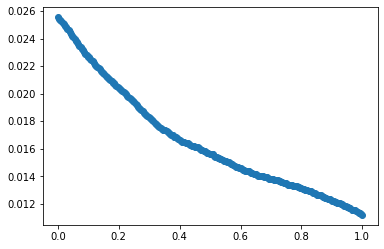

In [34]:
#plt.fill_between(X_test, percentiles[0, 0,:], percentiles[1, 0,:], color="lightblue")
Y = Y.reshape((-1,freqs))
plt.scatter(X,Y[245])
plt.plot(X,mean_rev[245])
#np.save('/scratch/dkn16/result_np_pol_suppix1_rfi0.5.npy',(np.array(Y)-means_rev).reshape((-1,256,256,Y.shape[-1])))

In [35]:
x0 = 0
y0 = 0
dim = 256
freqs = 256
selected = None
#selected = np.concatenate([np.arange(64),np.arange(32)+128,np.arange(32)+224])

cosmos = (HI+noise)[x0:x0+dim,y0:y0+dim,0:freqs]
#cosmos = cosmos[:,:,selected]
cosmos = cosmos - jnp.mean(cosmos,axis=(0,1))
cosmos = cosmos.reshape(dim*dim,-1)

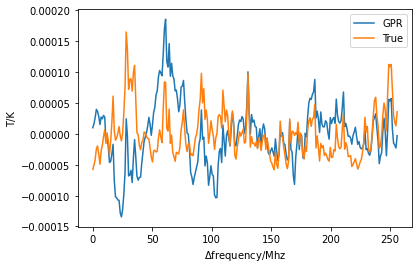

In [38]:
#i=50*250+200
i=240
#cosmos = HI[0:64,0:64].reshape(64*64,285)
plt.plot(X*freqs,Y[i]-mean_rev[i])

plt.plot(X*freqs,cosmos[i]/1000)
#plt.fill_between(X*freqs,Y[i]-perc_rev[0][ i,:], Y[i]-perc_rev[1][ i,:], color="lightblue")
plt.xlabel(r'$\Delta$frequency/Mhz')
plt.ylabel(r'T/K')
plt.legend(['GPR','True'])

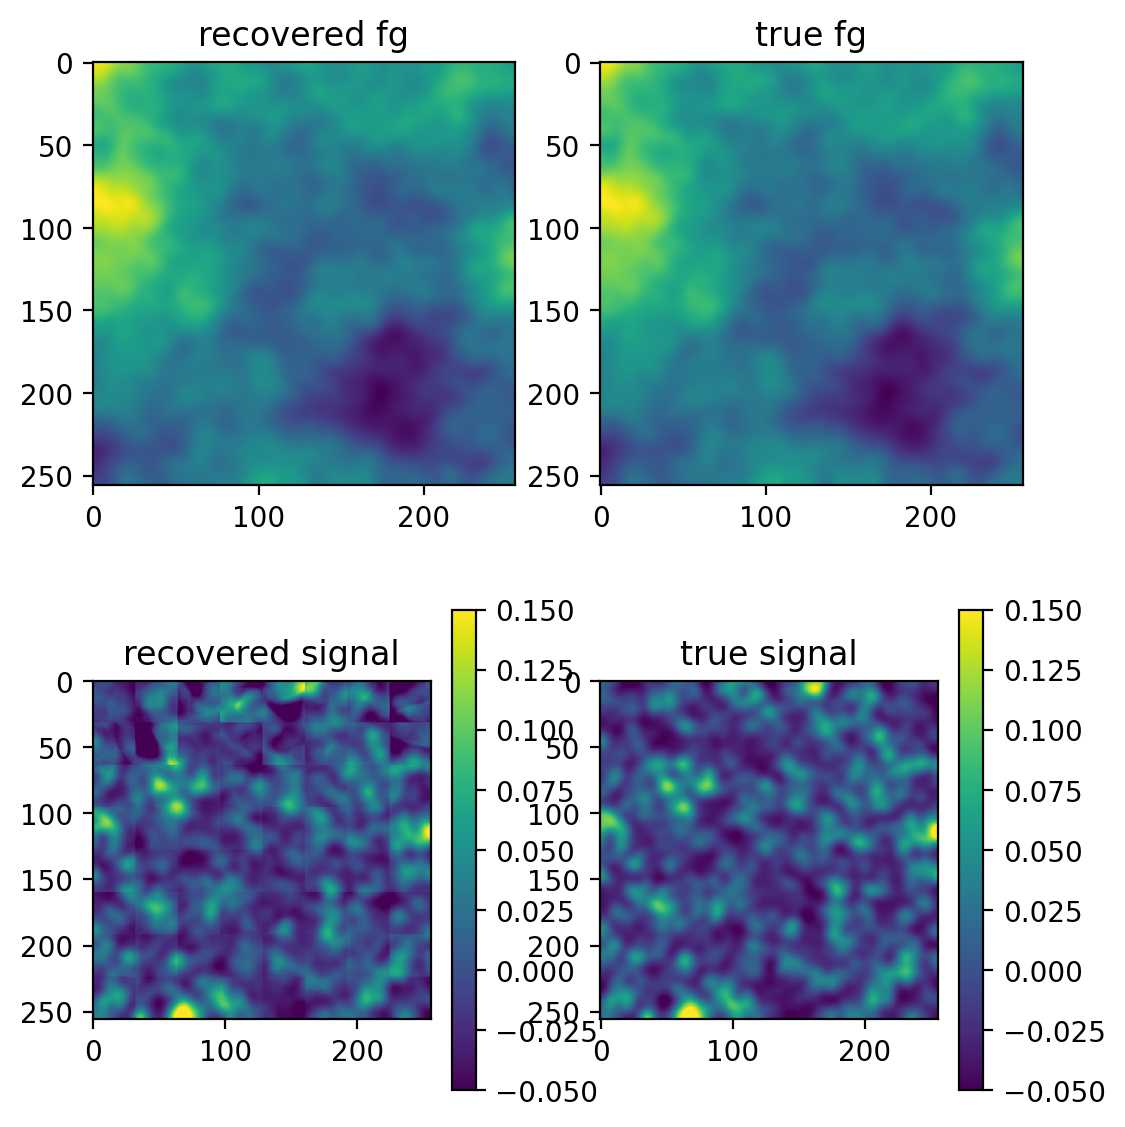

In [17]:
i=15
plt.figure(figsize=(6,7),dpi=200)
plt.subplot(2,2,1)
plt.imshow(mean_rev[:,i].reshape(dim,dim))
plt.title('recovered fg')
plt.subplot(2,2,2)
plt.imshow(Y[:,i].reshape(dim,dim))
plt.title('true fg')
plt.subplot(2,2,3)
plt.imshow((Y[:,i]-mean_rev[:,i]).reshape(dim,dim)*1000,vmax=0.15,vmin=-0.05)
plt.title('recovered signal')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(cosmos[:,i].reshape(dim,dim),vmax=0.15,vmin=-0.05)
plt.title('true signal')
plt.colorbar()